In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler



## Upload and Load the Data

In [ ]:
csv_url = '/content/weather_data.csv'


df = pd.read_csv(csv_url)
print(df['date'].head())



0    2014-01-01
1    2014-01-02
2    2014-01-03
3    2014-01-04
4    2014-01-05
Name: date, dtype: object


## Data Preprocessing

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
print(df.head())


            temperature
date                   
2014-01-01    10.248357
2014-01-02     9.950428
2014-01-03    10.362958
2014-01-04    10.820167
2014-01-05     9.961091


## Visualize the Temperature Data

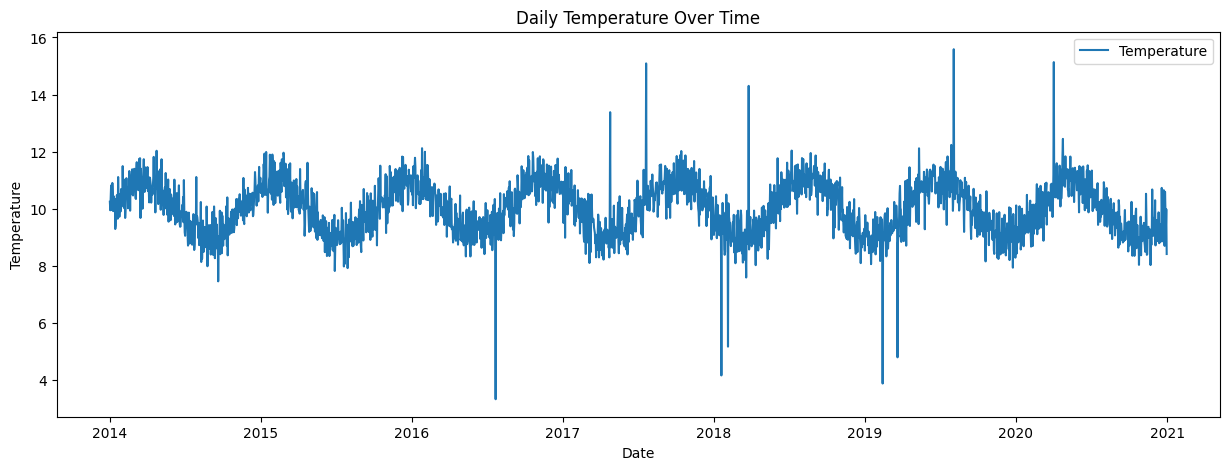

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


## Normalize the Data

In [ ]:
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(df[['temperature']])


## Create Sequences for LSTM


In [ ]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)


window_size = 30


sequences = create_sequences(temperature_scaled, window_size)
print('Sequences shape:', sequences.shape)


Sequences shape: (2528, 30, 1)


## Split the Data into Training and Testing Sets

In [ ]:
train_size = int(len(sequences) * 0.8)
X_train = sequences[:train_size]
X_test = sequences[train_size:]

print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)


Training data shape: (2022, 30, 1)
Testing data shape: (506, 30, 1)


## Build the LSTM Autoencoder Model

In [ ]:
# model architecture
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
    encoded = RepeatVector(input_shape[0])(encoded)
    # Decoder
    decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
    # Autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Training the model
history = model.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping]
)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 0.1384 - val_loss: 0.0167
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0061 - val_loss: 0.0278
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0209
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - los

## Plot Training and Validation Loss

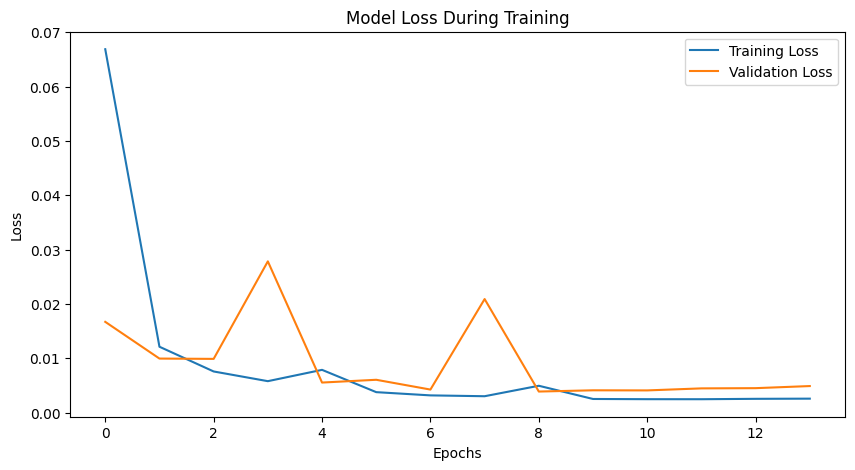

In [ ]:
# Ploting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Detect Anomalies

In [ ]:
# Predict on training and testing data
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

# Calculate reconstruction error (MSE)
train_mse = np.mean(np.power(X_train_pred - X_train, 2), axis=(1, 2))
test_mse = np.mean(np.power(X_test_pred - X_test, 2), axis=(1, 2))

# Determine the threshold for anomalies
threshold = np.mean(train_mse) + 3 * np.std(train_mse)
print('Reconstruction error threshold:', threshold)

# Identify anomalies in the test set
anomalies = test_mse > threshold
print('Number of anomalies detected:', np.sum(anomalies))


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Reconstruction error threshold: 0.009372770482134172
Number of anomalies detected: 4


# Visualize the Anomalies

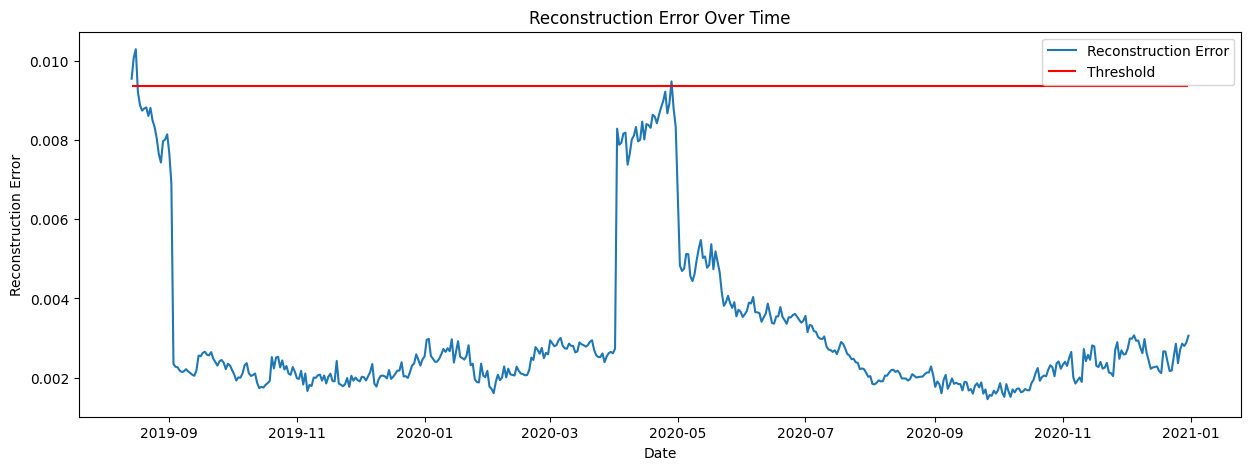

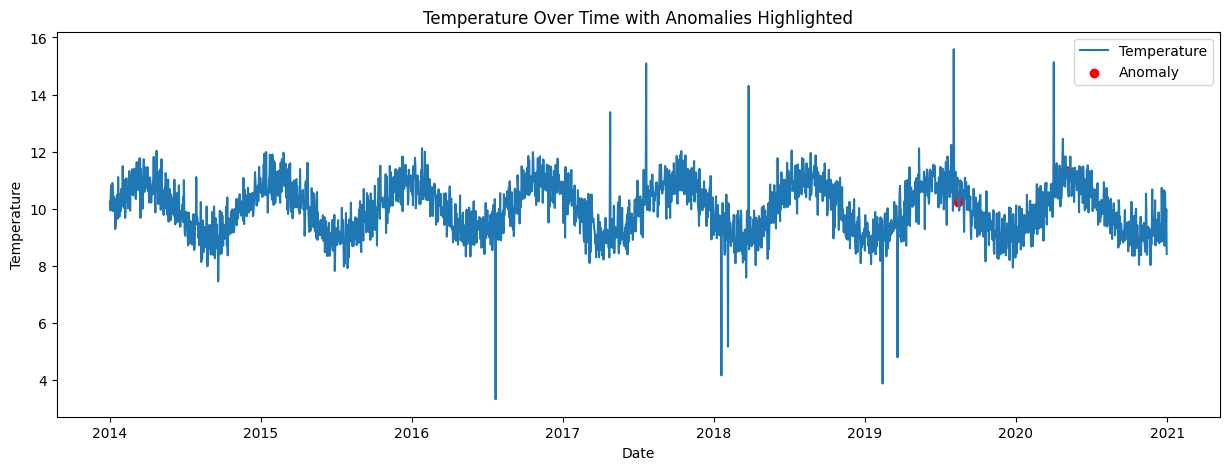

In [ ]:
# Get the corresponding timestamps for the test data
test_dates = df.index[window_size - 1 + train_size:]

# Create a DataFrame for anomalies
anomaly_df = pd.DataFrame({
    'date': test_dates,
    'reconstruction_error': test_mse,
    'anomaly': anomalies
})

# Plot reconstruction error over time
plt.figure(figsize=(15, 5))
plt.plot(anomaly_df['date'], anomaly_df['reconstruction_error'], label='Reconstruction Error')
plt.hlines(threshold, xmin=anomaly_df['date'].min(), xmax=anomaly_df['date'].max(), colors='r', label='Threshold')
plt.title('Reconstruction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

# Plot the temperature with anomalies highlighted
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.scatter(
    anomaly_df[anomaly_df['anomaly']]['date'],
    df.loc[anomaly_df[anomaly_df['anomaly']]['date'], 'temperature'],
    color='red',
    label='Anomaly'
)
plt.title('Temperature Over Time with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


## Review Detected Anomalies

In [ ]:
# Displaying the dates and temperatures where anomalies were found
anomalous_data = df.loc[anomaly_df[anomaly_df['anomaly']]['date']]
print('Anomalous data points:')
print(anomalous_data)

Anomalous data points:
            temperature
date                   
2019-08-15    10.315052
2019-08-16    10.477161


**INterpretation**

1. Load the Dataset

Loaded the dataset containing Date and Temperature columns. The Date was converted to a datetime format and set as the index.
Interpretation: This step ensures that the data is in a usable format for time series analysis.


2. Preprocess the Data

Normalized the temperature values to a range of 0 to 1 using MinMaxScaler.
Created sequences of 30 days to represent input windows for the LSTM model.
Split the data into training (80%) and testing (20%) sets.
Interpretation: Normalization scales the data for efficient model training, and splitting ensures the model is evaluated on unseen data.


3. Build the LSTM Autoencoder

Constructed an LSTM Autoencoder with:

Encoder: Reduces input to a latent representation.


Decoder: Reconstructs the input from the latent representation.


Model Summary:

Layers: Input → LSTM Encoder → RepeatVector → LSTM Decoder → TimeDistributed Dense

Total trainable parameters: 49,985

Interpretation: The autoencoder learns the normal temperature patterns by
reconstructing the input sequences.


4. Train the Model

Trained for up to 100 epochs with early stopping to prevent overfitting.
Training loss reduced significantly, showing the model learned the reconstruction task.

Interpretation: The model's decreasing loss indicates successful learning of the temperature sequence patterns.

5. Anomaly Detection

Calculated reconstruction error (MSE) for test sequences.
Defined the anomaly threshold as the mean training error plus three standard deviations.Identified days with reconstruction errors above the threshold as anomalies.

Results:
Threshold: 0.00937
Number of anomalies detected: 4

Interpretation: Higher reconstruction errors suggest unusual temperature patterns not seen during training.

6. Visualize the Results

Plotted:

Reconstruction error over time, highlighting the threshold.
Temperature data with anomalies marked in red.